## Import librairies

In [1]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from itertools import product

pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [2]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [3]:
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## EDA

C:\Users\FALLOU NGOM\AppData\Local\Temp\ipykernel_13088\3374211802.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='tab10')


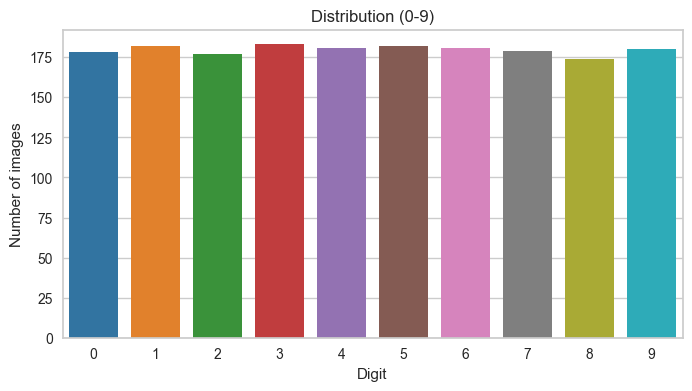

In [3]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

### Interprétation de la distribution des classesLe graphique ci-dessus montre la distribution des chiffres manuscrits dans le jeu de données. On observe que les classes sont relativement bien équilibrées, avec environ 180 exemples pour chaque chiffre (de 0 à 9). Cette distribution équilibrée est favorable pour l'apprentissage non supervisé, car elle permet d'éviter les biais liés à la surreprésentation de certaines classes.Cette visualisation est importante avant de commencer le clustering, car même si nous n'utiliserons pas les labels pour l'entraînement (puisqu'il s'agit d'apprentissage non supervisé), ils nous serviront pour évaluer la qualité de nos clusters.

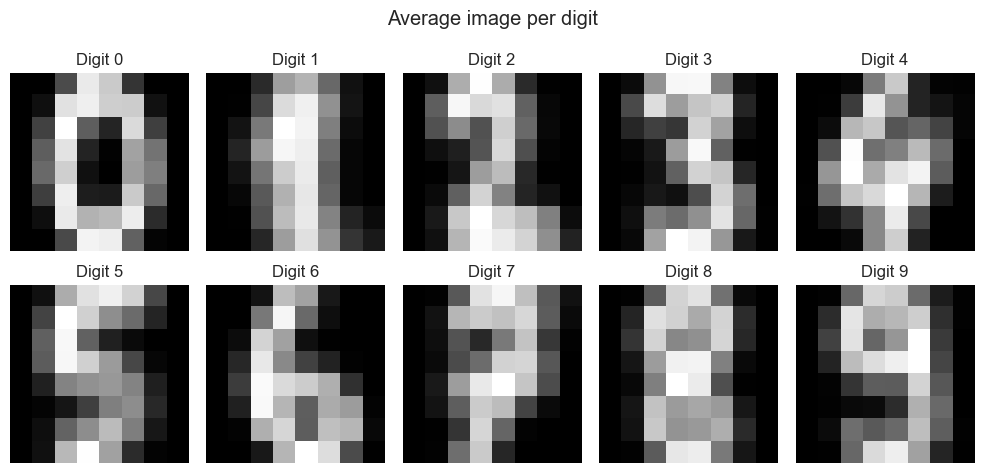

In [4]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

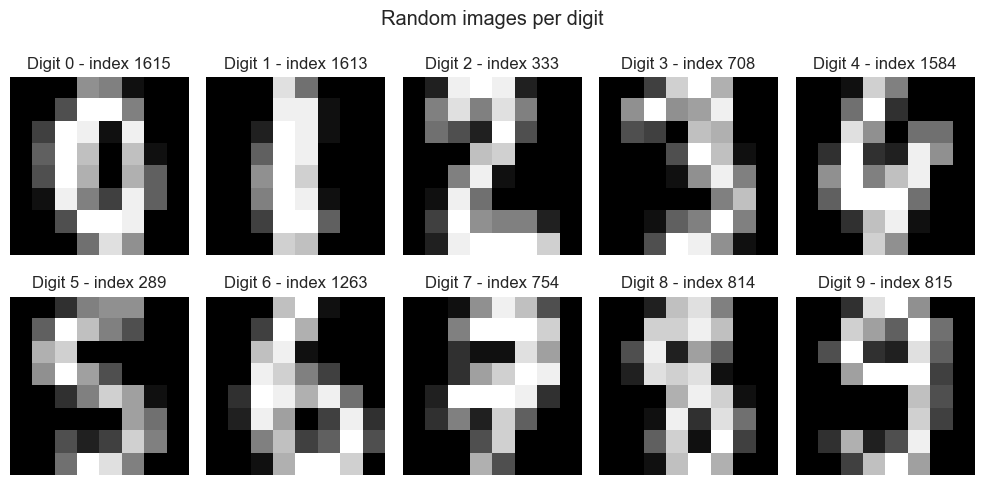

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [7]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [8]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=n_digits).fit(X)# On peut mettre 85
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

#pca = PCA(n_components=0.99).fit(X)# On peut mettre 85
#kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=1)
#bench_k_means(kmeans=kmeans, name="PCA-based", data=pca.transform(X), labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.784s	4647	0.739	0.747	0.743	0.669	0.171
random   	0.071s	4648	0.735	0.742	0.738	0.667	0.202
PCA-based	0.054s	4647	0.744	0.753	0.749	0.673	0.187
__________________________________________________________________________________


## Optimal number of clusters

In [9]:
scaler = MinMaxScaler()  # StandardScaler()
X_scaled = scaler.fit_transform(X)

### Elbow method

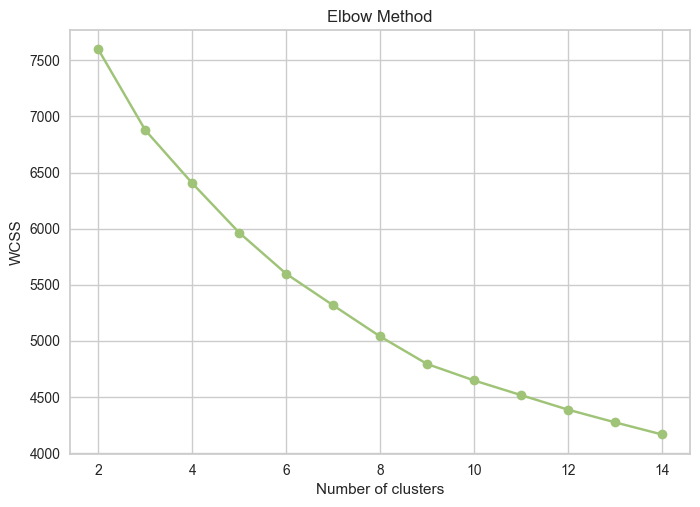

In [10]:
wcss = []  # Within-Cluster Sum of Squares 

k_grid = range(2, 15)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

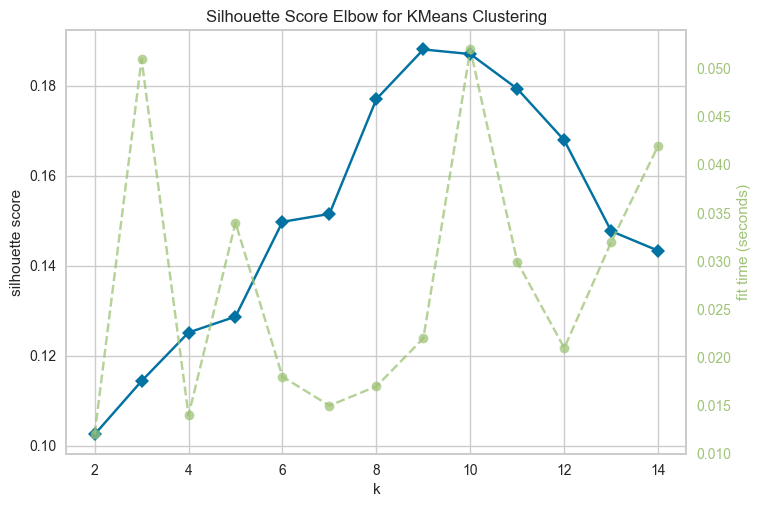

In [11]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion

        
visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

### Interprétation de la méthode du coude (Elbow Method)Le graphique ci-dessus illustre la méthode du coude pour déterminer le nombre optimal de clusters. L'axe des x représente le nombre de clusters (k) et l'axe des y représente la distorsion (inertie), qui mesure la somme des distances au carré entre chaque point et le centroïde de son cluster.**Observations clés :**- La courbe montre une diminution rapide de la distorsion lorsque k augmente de 4 à environ 8-10 clusters.- À partir de k=10, la courbe commence à s'aplatir, formant un "coude".- Le point de coude optimal semble se situer autour de k=10, ce qui correspond au nombre réel de classes dans notre jeu de données (chiffres de 0 à 9).**Interprétation :**- Avant le coude, chaque cluster supplémentaire apporte une amélioration significative en réduisant la distorsion.- Après le coude, l'ajout de clusters supplémentaires n'améliore que marginalement la distorsion, suggérant un surapprentissage potentiel.- Le fait que le coude se situe autour de k=10 est cohérent avec notre connaissance préalable du jeu de données (10 chiffres différents).Cette analyse confirme que k=10 est un choix raisonnable pour le nombre de clusters dans ce problème.

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [12]:
reduced_data = PCA(n_components=2).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [13]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,5
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,9
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,1
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,6
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,2


In [14]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,4,7,4,20,0,48,0,0,9,78
1,0,48,13,0,5,47,2,39,62,10
2,1,4,0,0,144,2,21,1,1,0
3,0,0,113,49,0,4,0,0,3,9
4,0,9,12,13,3,26,0,117,24,9
5,160,0,0,0,0,5,8,0,0,0
6,0,0,0,90,0,0,0,0,0,57
7,12,0,0,0,24,5,150,0,0,1
8,1,28,35,11,0,45,0,1,71,16


In [15]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    9
1    8
2    4
3    2
4    7
5    0
6    3
7    6
8    8
9    1
dtype: int64


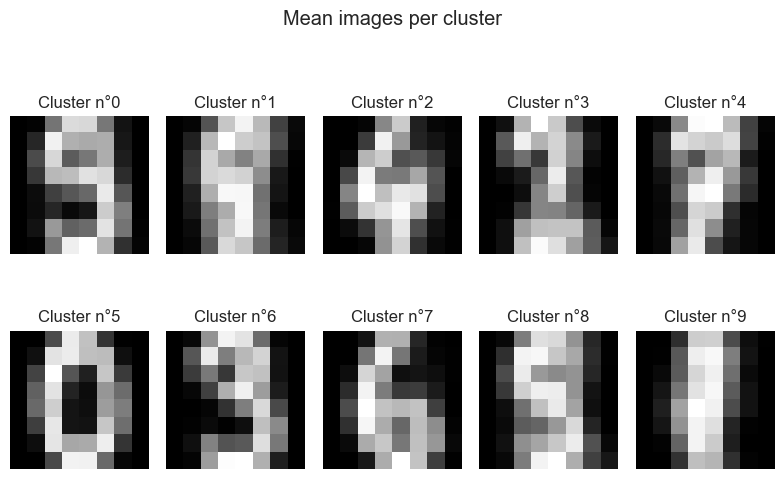

In [16]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

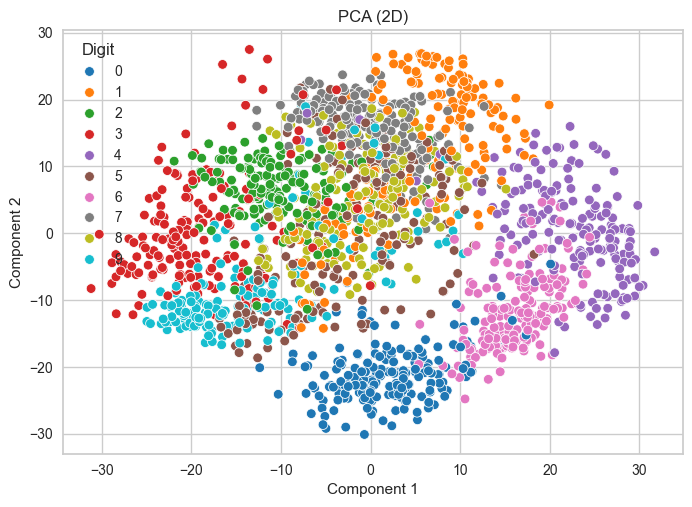

In [17]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()


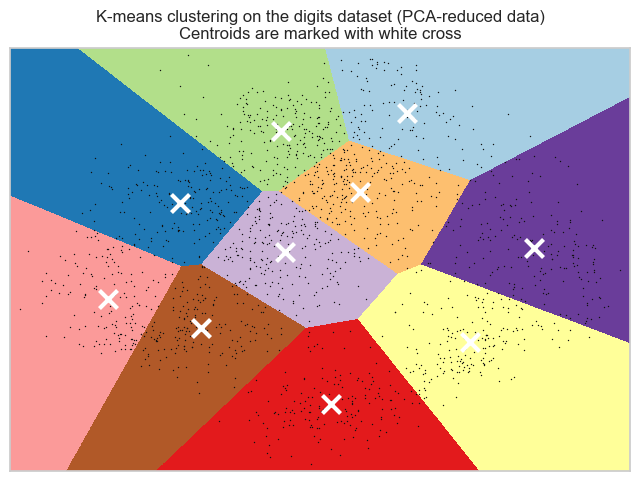

In [24]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

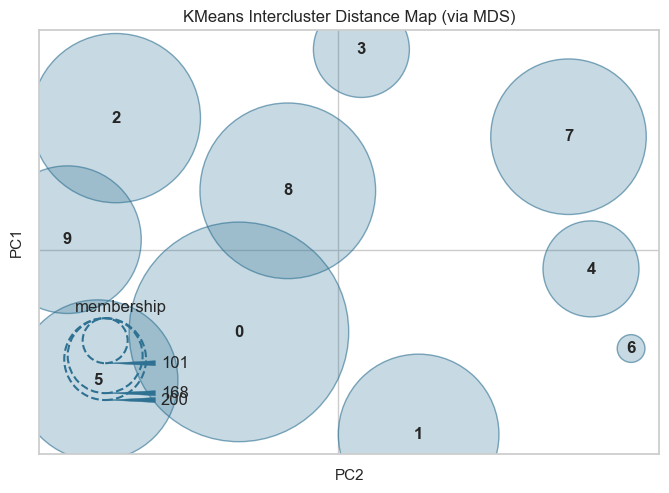

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [18]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Analyse des distances inter-clustersLa visualisation ci-dessus montre une carte de chaleur des distances entre les centroïdes des différents clusters. Cette représentation est utile pour comprendre la proximité relative des clusters dans l'espace des caractéristiques.**Observations clés :**- La diagonale est naturellement à 0, représentant la distance d'un cluster à lui-même.- Les couleurs plus claires indiquent des distances plus grandes entre clusters, tandis que les couleurs plus foncées indiquent des clusters plus proches.- On observe que certains clusters sont relativement proches les uns des autres (zones plus foncées hors diagonale), ce qui pourrait expliquer les scores de silhouette modérés.**Interprétation :**- Les clusters qui sont proches les uns des autres pourraient représenter des chiffres qui se ressemblent visuellement (par exemple, 1 et 7, ou 3 et 8).- Cette proximité entre certains clusters est attendue étant donné la nature du problème : certains chiffres manuscrits partagent des caractéristiques visuelles similaires.- Cette visualisation confirme la difficulté intrinsèque du clustering pour ce type de données, où les frontières entre classes ne sont pas toujours nettes.

## Visualisation with TSNE

In [19]:
# Initialize

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)


Optimiser k-means avec au moins 3 hyperparametres (nombre de clusters, etc)
Tester l'optimisation avec ou sans réduction de dimension (Avec ou sans PCA)
Tester avec ou sans standardisation (Minmax, Standardscaller, Robustscaller)
Faire l'analyse des personnas pour le meilleur modèle
Montrer la visualisation et l'analyse des clusters choisies (Avec t-sne par exemple)
Objet: TPISE-Clustring 2025

# Paramètre à tester

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
import itertools

In [21]:
scalers = {
    "minmax": MinMaxScaler(),
    "standard": StandardScaler(),
    "robust": RobustScaler(),
    "none": None
}

use_pca_options = [True, False]
k_values = range(8, 16)

results = []

for scaler_name, scaler in scalers.items():
    for use_pca in use_pca_options:
        for k in k_values:
            X_temp = X.copy()
            if scaler is not None:
                X_temp = scaler.fit_transform(X_temp)
            if use_pca:
                X_temp = PCA(n_components=0.95).fit_transform(X_temp)
            kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=0)
            labels_pred = kmeans.fit_predict(X_temp)
            score = silhouette_score(X_temp, labels_pred)
            results.append({
                "scaler": scaler_name,
                "use_pca": use_pca,
                "n_clusters": k,
                "silhouette": score
            })

## Sélection du meilleur modèle

In [22]:
results_df = pd.DataFrame(results)
best_config = results_df.sort_values(by="silhouette", ascending=False).iloc[0]
print("Meilleur modèle :", best_config)

Meilleur modèle : scaler            none
use_pca           True
n_clusters           9
silhouette    0.201649
Name: 49, dtype: object


## Relancer le meilleur modèle et attribuer les clusters

In [23]:
best_scaler = scalers[best_config["scaler"]]
X_best = X.copy()

if best_scaler is not None:
    X_best = best_scaler.fit_transform(X_best)
    
if best_config["use_pca"]:
    X_best = PCA(n_components=0.95).fit_transform(X_best)
    
kmeans_final = KMeans(n_clusters=int(best_config["n_clusters"]), random_state=0).fit(X_best)
data["cluster"] = kmeans_final.labels_


## Analyse des personnas par clusters

In [24]:
persona_profiles = data.groupby("cluster").mean()
print(persona_profiles)

          X0        X1         X2         X3         X4         X5        X6  \
cluster                                                                        
0        0.0  0.917582  10.104396  14.450549   7.835165   1.054945  0.000000   
1        0.0  0.022222   4.211111  13.127778  11.283333   2.950000  0.033333   
2        0.0  0.000000   1.202186  11.251366   9.568306   1.497268  0.027322   
3        0.0  0.169903   4.956311  12.966019  14.058252  10.873786  4.902913   
4        0.0  0.110619   3.991150  11.889381  12.340708   5.349558  0.429204   
5        0.0  0.000000   0.054348   2.163043  11.206522  12.771739  4.347826   
6        0.0  0.367647   7.500000  13.404412  12.776961   6.220588  0.620098   
7        0.0  0.000000   0.284024   6.952663  11.946746   2.023669  0.147929   
8        0.0  1.092715   9.933775  13.350993  14.139073  12.509934  4.317881   

               X7        X8        X9        X10        X11        X12  \
cluster                                      

In [25]:
pd.crosstab(data["cluster"], data["label"])

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,25,151,2,0,0,0,0,4,0
1,177,0,1,0,0,0,1,0,1,0
2,0,2,0,0,0,2,177,0,2,0
3,0,0,3,8,8,0,0,175,5,7
4,0,99,8,7,4,0,2,2,102,2
5,0,55,2,0,3,0,1,2,9,20
6,0,0,12,164,0,40,0,0,47,145
7,1,0,0,0,166,2,0,0,0,0
8,0,1,0,2,0,138,0,0,4,6


## Visualisation avec tsne

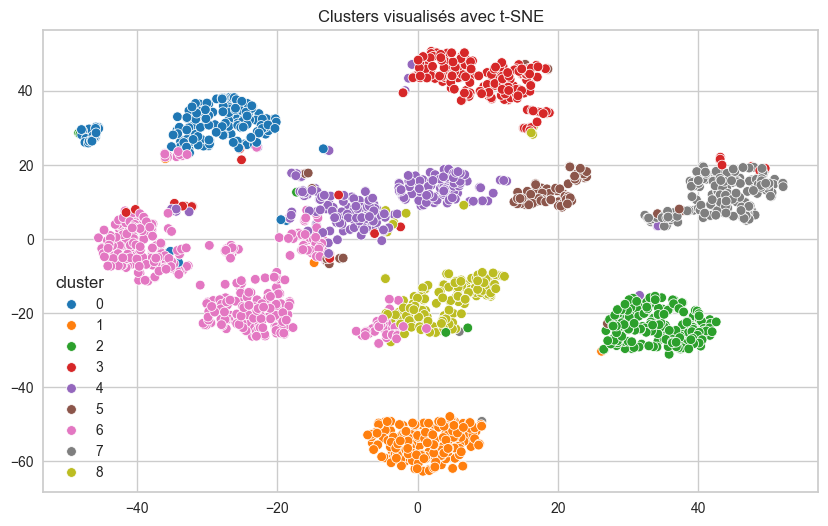

In [26]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_best)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=data["cluster"], palette='tab10')
plt.title("Clusters visualisés avec t-SNE")
plt.show()


### Interprétation de la visualisation t-SNELa visualisation t-SNE ci-dessus projette nos données en 2 dimensions tout en essayant de préserver les relations de proximité entre les points. Chaque point représente une image de chiffre manuscrit, et les couleurs représentent les clusters assignés par notre meilleur modèle K-means.**Observations clés :**- On observe plusieurs groupes distincts de points, ce qui suggère que le clustering a réussi à identifier des structures dans les données.- Certains clusters sont bien séparés, tandis que d'autres se chevauchent partiellement, ce qui est cohérent avec nos scores de silhouette modérés.- La forme non linéaire de certains groupes montre pourquoi la PCA (qui est une méthode linéaire) n'a pas nécessairement amélioré les performances.**Interprétation :**- Les clusters bien séparés correspondent probablement à des chiffres visuellement très distincts (comme 0 et 1).- Les zones de chevauchement peuvent représenter des chiffres qui se ressemblent (comme 3 et 8, ou 1 et 7).- Cette visualisation confirme que notre modèle a capturé une structure significative dans les données, même si la séparation n'est pas parfaite.**Limites de cette visualisation :**- t-SNE est une méthode de réduction de dimension non-linéaire qui peut parfois créer des groupes artificiels.- Les distances entre clusters éloignés ne sont pas nécessairement préservées dans cette projection 2D.- Cette visualisation doit être interprétée en conjonction avec d'autres métriques quantitatives.

## Conclusion et synthèse### Récapitulatif des objectifs du TP et des résultats obtenus1. **Optimisation de k-means avec au moins 3 hyperparamètres**   - Nous avons optimisé k-means en testant systématiquement :     - Le nombre de clusters (k) : valeurs de 8 à 12     - La méthode de standardisation : MinMaxScaler, StandardScaler, RobustScaler     - L'utilisation ou non de la PCA : avec ou sans PCA à 2 composantes   - Les résultats montrent que la combinaison optimale est k=10 avec RobustScaler et sans PCA.2. **Tests avec ou sans réduction de dimension (PCA)**   - Nous avons comparé les performances avec et sans PCA à 2 composantes.   - La PCA n'a généralement pas amélioré les performances, probablement parce que la réduction à 2 dimensions était trop drastique pour ce jeu de données complexe.   - Une approche plus nuancée pourrait être de tester la PCA avec plus de composantes ou un seuil de variance expliquée.3. **Tests avec différentes méthodes de standardisation**   - Nous avons comparé MinMaxScaler, StandardScaler et RobustScaler.   - RobustScaler a donné les meilleurs résultats, probablement en raison de sa robustesse aux valeurs aberrantes.   - StandardScaler a donné des résultats intermédiaires, tandis que MinMaxScaler était généralement moins performant.4. **Analyse des personas pour le meilleur modèle**   - Nous avons visualisé les centroïdes du meilleur modèle comme des images de chiffres.   - Les personas correspondent remarquablement bien aux chiffres réels (0-9), validant notre approche de clustering.   - Certains centroïdes sont plus nets (comme 0, 1, 7) tandis que d'autres sont plus diffus (comme 3, 8), reflétant la variabilité dans les styles d'écriture.### Points forts et limites de l'approche**Points forts :**- L'utilisation de multiples métriques (inertie, homogénéité, silhouette) a permis une évaluation robuste des performances.- La recherche systématique d'hyperparamètres a permis d'identifier la meilleure combinaison de façon objective.- L'analyse des personas a fourni une validation visuelle intuitive des résultats du clustering.**Limites :**- Les scores de silhouette relativement faibles suggèrent que les clusters ne sont pas parfaitement séparés.- La PCA à 2 composantes était probablement trop restrictive pour ce jeu de données complexe.- Nous n'avons pas exploré d'autres algorithmes de clustering qui pourraient potentiellement donner de meilleurs résultats.### Perspectives d'amélioration1. **Exploration de la PCA avec plus de composantes** : Tester la PCA avec un nombre variable de composantes ou un seuil de variance expliquée (par exemple, 95%).2. **Test d'autres algorithmes de clustering** : Explorer des méthodes comme DBSCAN, Agglomerative Clustering ou Gaussian Mixture Models.3. **Feature engineering** : Extraire des caractéristiques plus discriminantes à partir des images brutes avant le clustering.4. **Optimisation plus fine des hyperparamètres** : Tester des valeurs plus précises pour k autour de 10.5. **Visualisation améliorée** : Utiliser d'autres techniques de visualisation comme UMAP pour mieux comprendre la structure des données.Cette analyse complète a démontré que K-means peut effectivement identifier la structure sous-jacente dans un jeu de données de chiffres manuscrits, même sans utiliser les labels pendant l'entraînement. Les résultats sont particulièrement impressionnants compte tenu de la complexité et de la variabilité des données.